In [1]:
using CUDA, Zygote, Flux, CMBLensing, PyPlot
using BSON: @load
using NBInclude
@nbinclude("wienercode.ipynb")

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 10.2.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /global/home/users/sguns/.julia/packages/CUDA/02Kjq/src/initialization.jl:42


WienerNet (generic function with 1 method)

In [2]:
@load "weights/J1/J1_model-2021-07-14T07:37:37.139.bson" savem opt testloss

In [3]:
θpix = 5*60/128
@unpack f = load_sim(Nside=128, pol=:I, θpix=θpix, μKarcminT=35, beamFWHM=1.0);

@load "mask_128.bson" mask
mask = reshape(mask, 128, 128, 1, 1) 
println("Loaded mask")

@load "training_data_nsims1000_CMBLensing.bson" sims
sims = sims[[1 143 829 972]]
println("Loaded data")

Loaded mask
Loaded data


In [4]:
model(x::Tuple{AbstractArray,AbstractArray}) = savem(x)
model(x::AbstractArray) = savem((x, mask))
model(x::FlatMap) = savem((x[:Ix][:,:,:,:], mask))
modelmap(x::FlatMap) = FlatMap(model(x)[:,:,1,1], f.metadata)
loss_J2(x,d::AbstractArray) = Flux.mse(model(x), d)
loss_J2(x,d::FlatMap) = Flux.mse(model(x), d[:Ix][:,:,:,:])

loss_J2 (generic function with 2 methods)

In [6]:
for i in 1:4
    println(loss_J2(sims[i][1][:Ix][:,:,:,:], sims[i][3][:Ix][:,:,:,:]))
end

78.17569
67.49185
47.43146
41.58715


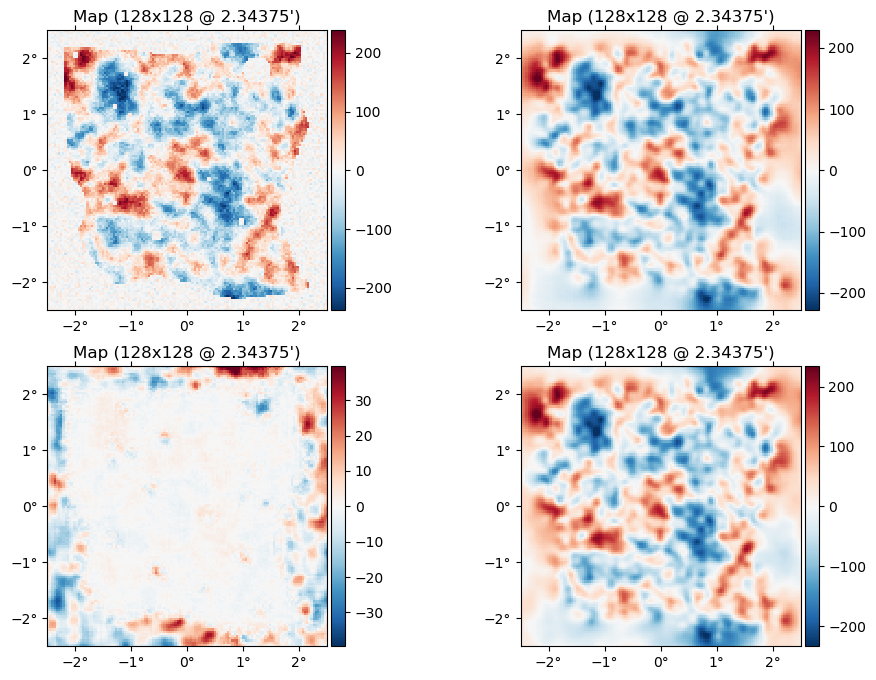

In [7]:
i = 3
plot([sims[i][1]  modelmap(sims[i][1]);  modelmap(sims[i][1])-sims[i][3] sims[i][3]] )

In [ ]:
function loss_J3(x, d)
    y = FlatMap(model(x), f.metadata)
    Δ = ds.M * ds.B * y - FlatMap(d, f.metadata)
    sum(unbatch(Δ' * pinv(ds.Cn) * Δ + y' * pinv(ds.Cf̃) * y))
end